In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os


np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) # as_frame false to prevent data from being returned as DF
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

784 features denoting each individual pixel (28x28 image)

In [5]:
y.shape

(70000,)

In [6]:
a_num = X[1]
a_num_image = a_num.reshape(28,28)

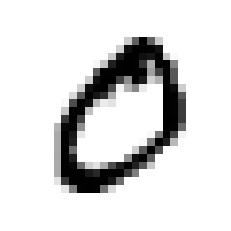

In [7]:
plt.imshow(a_num_image,cmap='binary')
plt.axis('off')
plt.show()

In [8]:
y[1]

'0'

In [9]:
y = y.astype(np.uint8)

data already shuffled for us
* two reasons why shuffling is important here

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a binary classifier

In [11]:
y_train_5 = (y_train == 5) # getting the y labels
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000,tol=1e-3,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([a_num])

array([False])

trying to evualuate an actual 5

In [14]:
sgd_clf.predict([X[0]])

array([ True])

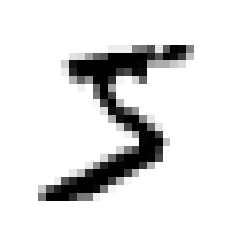

In [15]:
plt.imshow(X[0].reshape(28,28),cmap='binary')
plt.axis('off')
plt.show()

# Performance measures

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

accuracy not the best metric here

custom way to implement the cross_val_score function


In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


showing how accuracy gives even this classifier good scores

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) 
    #an array of just zeros is returned

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

# confusion matrix

**why are we using cross_val_predict?**

In [20]:

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)



cross_val_predict gives us predictions with a model didn't see data during training

In [21]:

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [22]:
y_train_perfect_predictions = y_train_5  # in a perfect model
confusion_matrix(y_train_5, y_train_perfect_predictions)



array([[54579,     0],
       [    0,  5421]])

# Precision and recall

How precision and recall together form a better metric?

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [26]:


cm[1, 1] / (cm[1, 0] + cm[1, 1])



0.6511713705958311

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846


# Precision/Recall Trade-off

In [28]:
y_scores = sgd_clf.decision_function([a_num])
y_scores #this wasn't a 5

array([-5897.37359354])

In [29]:
sgd_clf.decision_function([X[0]]) # this was a 5

array([2164.22030239])

In [30]:


threshold = 0 #threshold is zero
y_some_digit_pred = (y_scores > threshold)



In [31]:
y_some_digit_pred

array([False])

**Why are we specifying the method?**

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

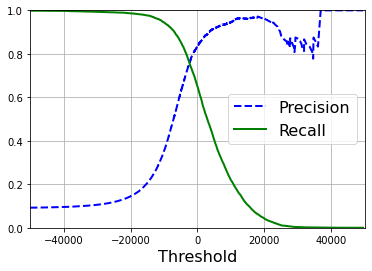

In [35]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

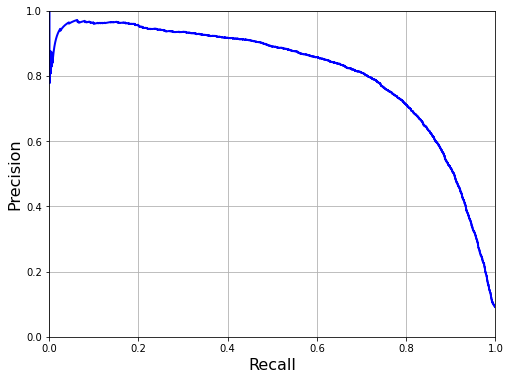

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

How is np.argmax working?

In [37]:


threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]



In [38]:
threshold_90_precision

3370.0194991439557

In [39]:
y_scores #decisions functions so now we will compare them to new threshold

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [40]:

y_train_pred_90 = (y_scores >= threshold_90_precision)


In [41]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [42]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC Curve

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

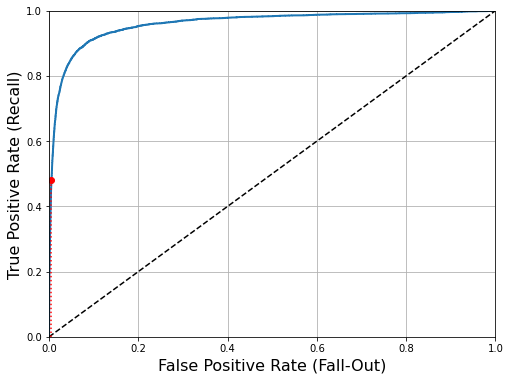

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()

**How to decide between the PR curve and roc_auc_score?**

In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [46]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100,random_state=42)
y_proba_forest = cross_val_predict(forest_clf,X_train, y_train_5, cv=3, method='predict_proba')

**What are these scores really?**

In [47]:
y_scores_forest = y_proba_forest[:,1] 

In [48]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

**Which model is better why?**

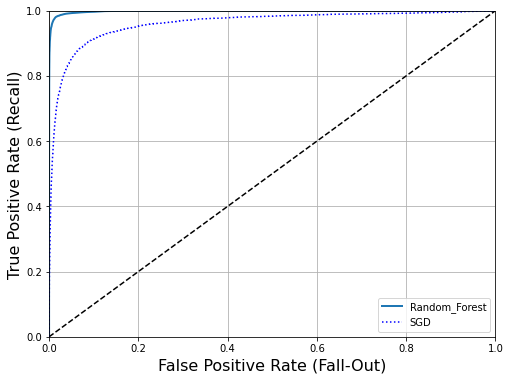

In [49]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, 'Random_Forest')
plt.plot(fpr,tpr,"b:", label='SGD' )
plt.legend()
plt.show()

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict')

In [52]:
precision_score(y_train_5,y_train_pred_forest)

0.9905083315756169

In [53]:
recall_score(y_train_5,y_train_pred_forest)

0.8662608374838591

# Multiclass classification

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train, y_train)
svm_clf.predict([a_num])

In [ ]:
svm_clf.predict([X[0]])

In [ ]:
score_0 = svm_clf.decision_function([a_num])
score_5 = svm_clf.decision_function([X[0]])

In [ ]:
np.argmax(score_0)

In [ ]:
np.argmax(score_5)

In [ ]:
svm_clf.classes_

In [ ]:
svm_clf.classes_[5]

**Purpose of the following?**

Using an ovrclassifier to explore functionality with a svc

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000],y_train[:1000])


Testing the model out

In [ ]:
ovr_clf.predict([a_num])

In [ ]:
len(ovr_clf.estimators_)

now classifying with stochastic gradient descent

In [ ]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([a_num])

Seeing how model arrived to conclusion of this number

In [ ]:
sgd_clf.decision_function([a_num])

Our model is now complex enough to consider accuracy as an valuebale measure

In [ ]:
scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')
scores

**the scaler actually helps the algorithm**

In [ ]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X_train_scaled = standardizer.fit_transform(X_train.astype(np.float64))

In [ ]:
scores = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
scores

# error analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [ ]:
matrix = confusion_matrix(y_train, y_train_pred)
matrix

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plot_confusion_matrix(matrix)

In [ ]:
row_sums = matrix.sum(axis=1, keepdims=True)
norm_conf_mx = matrix / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# multilabel classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = y_train >= 7
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]


In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([a_num])

In [ ]:
knn_clf.predict([X[0]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)


In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

# Multi output classification


In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

In [ ]:
knn_clf.fit(X_train_mod,y_train_mod)


In [ ]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])

In [ ]:
clean_digit

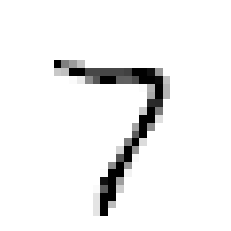

In [93]:
plot_digit(clean_digit)